#  Edge Graph Convolutional NN for Jet anomaly (variational) autoencoder  using jet constituents from offline delphes data


In [ ]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import setGPU
from importlib import reload

In [ ]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

import models.models as models
reload(models)
import models.losses as losses
reload(losses)
import utils.preprocessing as prepr
reload(prepr)

In [ ]:
#Data Samples
DATA_PATH = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/'

TRAIN_NAME = 'qcd_sqrtshatTeV_13TeV_PU40_NEW_sideband'
filename_bg = DATA_PATH + TRAIN_NAME + '_parts/' + TRAIN_NAME + '_000.h5'
batch_size = 128
train_set_size = int((5*10e4//batch_size)*batch_size)

In [ ]:
nodes_n, feat_sz, particles_bg  = prepr.prepare_data_constituents(filename_bg,train_set_size,0,train_set_size+1)


In [ ]:

# BG validation
VALID_NAME = 'qcd_sqrtshatTeV_13TeV_PU40_NEW_EXT_sideband'
filename_bg_valid = DATA_PATH + VALID_NAME + '_parts/' + VALID_NAME + '_000.h5'
valid_set_size = int((10e3//batch_size)*batch_size)
_,_, particles_bg_valid = prepr.prepare_data_constituents(filename_bg_valid,valid_set_size,0,valid_set_size+1)



In [ ]:
#BG test
_,_, particles_bg_test = prepr.prepare_data_constituents(filename_bg_valid,5000,valid_set_size+1,valid_set_size+5000)


In [ ]:
#signal
SIG_MASS = '3.5'
SIG_NAME = 'RSGraviton_WW_NARROW_13TeV_PU40_'+SIG_MASS+'TeV_NEW'
filename_sig = DATA_PATH + SIG_NAME + '_parts/' + SIG_NAME + '_concat_001.h5'
_,_, particles_sig = prepr.prepare_data_constituents(filename_sig,5000,0,5000)

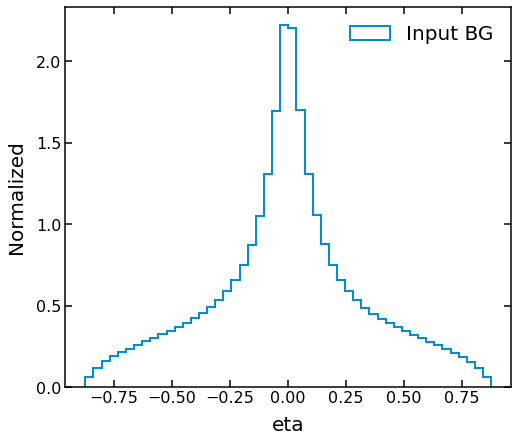

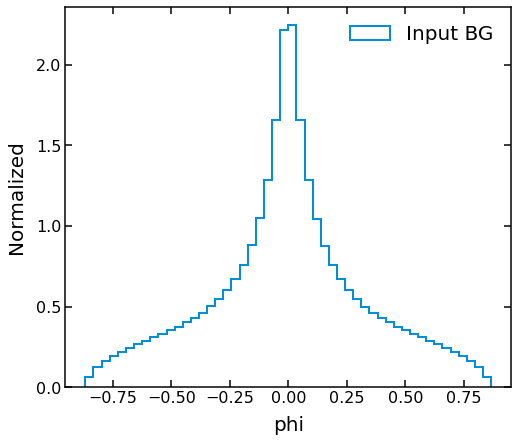

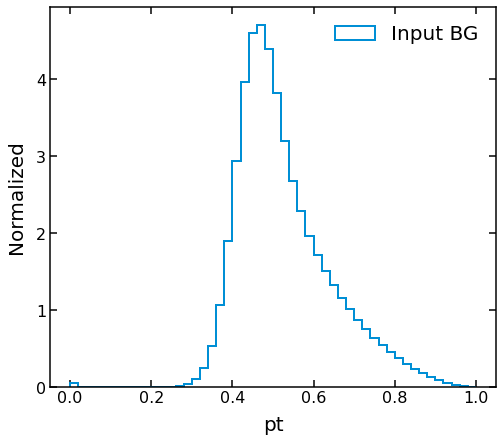

In [160]:
feats = 'eta,phi,pt'.split(',')
for i in range(0,3):
    xmin = np.quantile(particles_bg[:,:,i].flatten(),0.05)
    xmax = np.quantile(particles_bg[:,:,i].flatten(),0.98)
    plt.figure()
    plt.hist(particles_bg[:,:,i].flatten(), bins=50, label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(loc='upper right')
    #plt.semilogy()
    plt.show()

## Define KNN algorithm to find nearest node neightbours 

In [9]:


# A shape is (N, P_A, C), B shape is (N, P_B, C)
# D shape is (N, P_A, P_B)
def batch_distance_matrix_general(A, B):
    with tf.name_scope('dmat'):
        r_A = tf.reduce_sum(A * A, axis=2, keepdims=True)
        r_B = tf.reduce_sum(B * B, axis=2, keepdims=True)
        m = tf.matmul(A, tf.transpose(B, perm=(0, 2, 1)))
        D = r_A - 2 * m + tf.transpose(r_B, perm=(0, 2, 1))
        return D


def knn(num_points, k, topk_indices, features):
    # topk_indices: (N, P, K)
    # features: (N, P, C)
    with tf.name_scope('knn'):
        queries_shape = tf.shape(features)
        batch_size = queries_shape[0]
        batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1, 1)), (1, num_points, k, 1))
        indices = tf.concat([batch_indices, tf.expand_dims(topk_indices, axis=3)], axis=3)  # (N, P, K, 2)
        return tf.gather_nd(features, indices)


def knn_diff(X,K):
    """EdgeConv
    Args:
        K: int, number of neighbors
    Inputs:
        X: point features (eta, phi, Pt)
    Returns:
        neighbours features differences
    """

    # Define node coordinates and features ( original ParticleNET uses only Pt as node features ! )
    pts = X[:,:,1:3] # (Eta,Phi) coordinates of points ( graph nodes )
    fts = X          # (Pt,Eta,Phi) node features ( graph node features )
    num_points = X.shape[1]

    # distance
    D = batch_distance_matrix_general(pts, pts)  # (N, P, P)
    _, indices = tf.nn.top_k(-D, k=K + 1)  # (N, P, K+1)
    indices = indices[:, :, 1:]  # (N, P, K)

    # Finds nodes nearest neighbours features differences
    knn_fts = knn(num_points, K, indices, fts)  # (N, P, K, C)
    knn_fts_center = tf.tile(tf.expand_dims(fts, axis=2), (1, 1, K, 1))  
    knn_fts = tf.subtract(knn_fts, knn_fts_center)  # (N, P, K, C)

    return knn_fts



## Define EdgeGraphConv Model 

EdgeGraphConv implements a modified version of DGCNN where we use a Conv1D instead of a Conv2D in order to define the convolution over the graph nodes and edges. Notice that a Conv1D layer uses a kernel_size=1 and stride=1 over the nodes(edges), so it's equivalent to apply a MLP to agregate the  nodes(edges) features. In Spektral EdgeConv uses directly an MLP for that. 

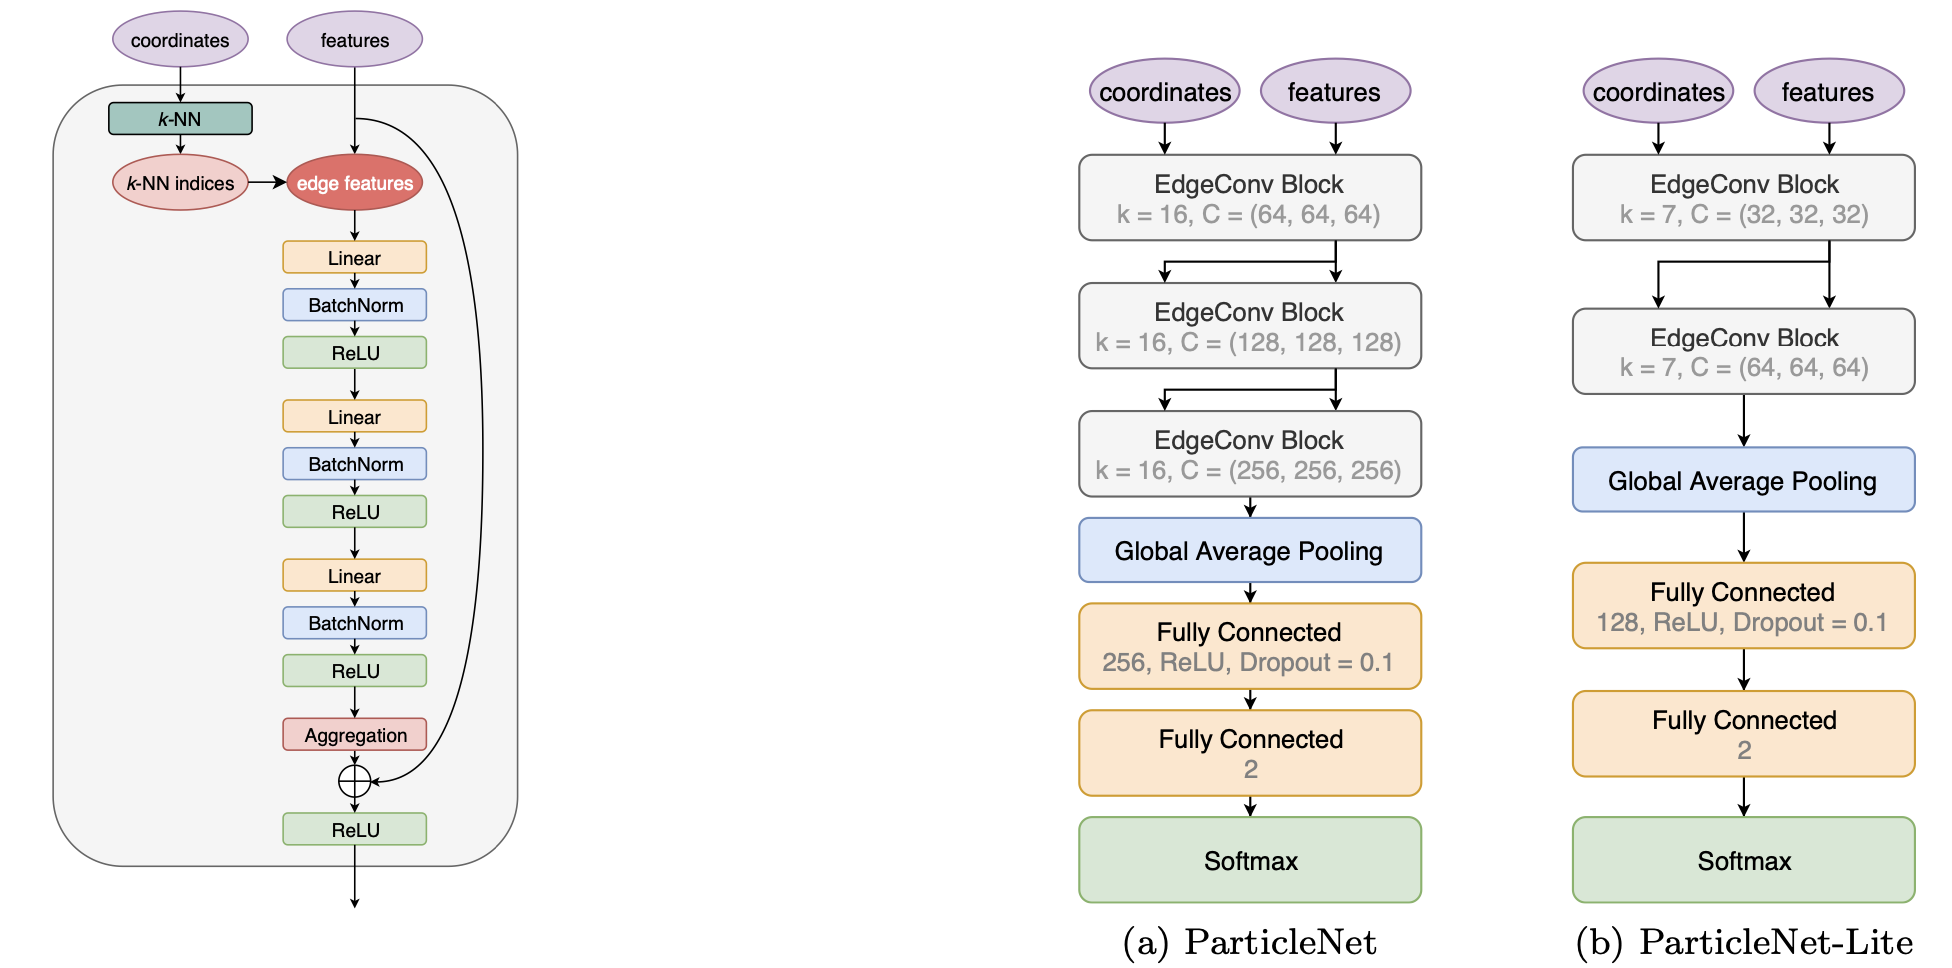


In [10]:
# baseline keras model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.layers import BatchNormalization, MaxPool1D, Conv1D
from tensorflow.keras.layers import Input, Activation, Dense, Flatten , LeakyReLU
from tensorflow.keras import utils

import models.layers as lays
reload(lays)


<module 'models.layers' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/models/layers.py'>

In [71]:
# baseline keras model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.layers import BatchNormalization, MaxPool1D, Conv1D
from tensorflow.keras.layers import Input, Activation, Dense, Flatten , LeakyReLU
from tensorflow.keras import utils

import models.layers as lays
reload(lays)

###########################################################################
# Define GraphConv Model 

point_channels = 20    #20 
edge_channels  = 20    #20
nhidden = int(nodes_n*feat_sz/2) 

k=15                   
#'''

##############################################################################

# Instantiate Tensorflow input tensors in Batch mode 
in_points = Input(shape=(nodes_n,feat_sz), name="in_points")

# Input point features BatchNormalization 
h = BatchNormalization(name='BatchNorm_points')(in_points)

# Conv1D with kernel_size=nfeatures to implement a MLP like aggregation of 
#   input point features ( pt, eta_rel, phi_rel)

h_points = Conv1D(point_channels, kernel_size=1, strides=1
                  , activation=LeakyReLU(alpha=0.3)
                  , use_bias="True"
                  , name='Conv1D_points')(h) #can be substituted with graph conv layer,
                                            #because this is only fully conencted, e.g. zeros will be connected as well
    

# Instantiate Tensorflow input tensors in Batch mode 
in_edges = Input(shape=(nodes_n,k*feat_sz), name="in_edges")


# Input edges features BatchNormalization 
h = BatchNormalization(name='BatchNorm_edges')(in_edges)


h_edges  = Conv1D(edge_channels, kernel_size=1, strides=1
                  , activation=LeakyReLU(alpha=0.3)
                  , use_bias="True"
                  , name='Conv1D_edges')(h)

# Concatenate points+edge features                           
#        out = Activation(activation, name='Activation_features')(sc + fts)  # (N, P, C')
#        out = sc+fts
h = tf.concat([h_points,h_edges],axis=2)


# Flatten to format for MLP input
h=Flatten(name='Flatten')(h)
print("MLP input h =",h)

#########################Autoencoder#################
hidden = Dense(nhidden, name = 'hidden',activation=LeakyReLU(alpha=0.3) )(h)

h = Dense((point_channels+edge_channels)*nodes_n,activation=LeakyReLU(alpha=0.3) )(hidden)
h = layers.Reshape((nodes_n,point_channels+edge_channels), input_shape=((point_channels+edge_channels)*nodes_n,))(h) 

out = Conv1D(3, kernel_size=1, strides=1
                  , activation=LeakyReLU(alpha=0.3)
                  , use_bias="True"
                  , name='Conv1D_out')(h)

model = Model(inputs=[in_points,in_edges], outputs=out,name='ae')
#model.summary()


##########################################################


################### VAE ##################################

# Dense layers for VAE, this whole part (+abvoe) is encoder
#z_mean = Dense(nhidden, name = 'z_mean',activation='relu' )(h)
#z_log_var = Dense(nhidden, name='z_log_var', activation='relu' )(h)
#batch = tf.shape(z_mean)[0]
#dim = tf.shape(z_mean)[1]
#epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
#z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
#encoder = tf.keras.Model(inputs=[in_points,in_edges], outputs=[z, z_mean, z_log_var])
#encoder.summary()

# Defining decoder
#d_i   = Input(shape=(nhidden, ), name='decoder_input')
#h = Dense((point_channels+edge_channels)*nodes_n,activation=LeakyReLU(alpha=0.3) )(d_i)
#h = layers.Reshape((nodes_n,point_channels+edge_channels), input_shape=((point_channels+edge_channels)*nodes_n,))(h) 
#o = Conv1D(3, kernel_size=1, strides=1
#                  , activation=LeakyReLU(alpha=0.3)
#                  , use_bias="True"
#                  , name='Conv1D_out')(h)
# Instantiate decoder
#decoder = Model(d_i, o, name='decoder')
#decoder.summary()

# Build VAE model
#out = decoder(encoder([in_points,in_edges])[0]) #taking z, as encoder returns 3 outputs
#model = Model(inputs=[in_points,in_edges], outputs=out,name='vae')
#model.summary()

##########################################################






MLP input h = Tensor("Flatten/Reshape_8:0", shape=(None, 800), dtype=float32)


In [59]:
import models.models as models
reload(models)
nhidden = int(nodes_n*feat_sz/4) 

k=7
ae = models.EdgeConvAutoEncoder(nodes_n=nodes_n, feat_sz=feat_sz, k_neighbors=k, activation=LeakyReLU(alpha=0.3),latent_dim=nhidden)
#vae = models.EdgeConvVariationalAutoEncoder(nodes_n=nodes_n, feat_sz=feat_sz,k_neighbors=k, activation=LeakyReLU(alpha=0.3),
                                #latent_dim=nhidden,beta_kl=10,kl_warmup_time=5)


Model: "EdgeConvEncoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in_points (InputLayer)          [(None, 10, 3)]      0                                            
__________________________________________________________________________________________________
in_edges (InputLayer)           [(None, 10, 21)]     0                                            
__________________________________________________________________________________________________
BatchNorm_points (BatchNormaliz (None, 10, 3)        12          in_points[0][0]                  
__________________________________________________________________________________________________
BatchNorm_edges (BatchNormaliza (None, 10, 21)       84          in_edges[0][0]                   
____________________________________________________________________________________

## Run training
Here, we run the training.

In [60]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import setGPU 

optim = Adam(learning_rate=0.001)
ae.compile(optimizer=optim, run_eagerly=True)
#vae.compile(optimizer=optim, run_eagerly=True) 

In [61]:
# early stopping callback
es = EarlyStopping(monitor='val_loss', patience=5,verbose=2)

# Learning rate scheduler 
ls = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,verbose=2)

kl_beta_callback = models.KLWarmupCallback()   

# Training data 
diffs_train = knn_diff(particles_bg,k) # (batch,constit,k_neighbour,feat_diff)
edge_feats_train = tf.reshape(diffs_train,[-1,nodes_n,k*feat_sz])   # reshape edges (N,nconstit*K*nfeat)

# Validation data 
diffs_valid = knn_diff(particles_bg_valid,k) # (batch,constit,k_neighbour,feat_diff)
edge_feats_valid = tf.reshape(diffs_valid,[-1,nodes_n,k*feat_sz])   # reshape edges (N,nconstit*K*nfeat)

print("point_feats shape= ",particles_bg.shape)
print("edge_feats shape= ",edge_feats_train.shape)

#vae or ae
history = ae.fit((particles_bg, edge_feats_train) , particles_bg,
                    validation_data = ((particles_bg_valid, edge_feats_valid) , particles_bg_valid),
                    epochs=40, 
                    batch_size=256, 
                    verbose=1,
                    callbacks=[es,ls]) #,kl_beta_callback
                  #  callbacks=[es,ls,kl_beta_callback])



point_feats shape=  (99968, 10, 3)
edge_feats shape=  (99968, 10, 21)
Epoch 1/40
391/391 [==============================] - 10s 25ms/step - val_loss: 0.1389
Epoch 2/40
391/391 [==============================] - 9s 24ms/step - val_loss: 0.1006
Epoch 3/40
391/391 [==============================] - 9s 24ms/step - val_loss: 0.0849
Epoch 4/40
391/391 [==============================] - 9s 24ms/step - val_loss: 0.0802
Epoch 5/40
391/391 [==============================] - 10s 24ms/step - val_loss: 0.0782
Epoch 6/40
391/391 [==============================] - 9s 23ms/step - val_loss: 0.0758
Epoch 7/40
391/391 [==============================] - 7s 19ms/step - val_loss: 0.0749
Epoch 8/40
391/391 [==============================] - 7s 18ms/step - val_loss: 0.0741
Epoch 9/40
391/391 [==============================] - 7s 18ms/step - val_loss: 0.0738
Epoch 10/40
391/391 [==============================] - 7s 18ms/step - val_loss: 0.0740
Epoch 11/40
391/391 [==============================] - 9s 23ms/step

In [62]:
diffs_bg_test = knn_diff(particles_bg_test,k) # (batch,constit,k_neighbour,feat_diff)
edge_feats_bg_test = tf.reshape(diffs_bg_test,[-1,nodes_n,k*feat_sz])   # reshape edges (N,nconstit*K*nfeat)

diffs_sig = knn_diff(particles_sig,k) # (batch,constit,k_neighbour,feat_diff)
edge_feats_sig = tf.reshape(diffs_sig,[-1,nodes_n,k*feat_sz])   # reshape edges (N,nconstit*K*nfeat

In [63]:
Y_bg_predict = ae.predict([particles_bg_test,edge_feats_bg_test])
Y_sig_predict = ae.predict([particles_sig,edge_feats_sig])

In [64]:
#Y_bg_predict, _, _, _ = vae.predict((particles_bg_test,edge_feats_bg_test))
#Y_sig_predict, _, _, _ = vae.predict((particles_sig,edge_feats_sig))

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

In [65]:
loss_bg = losses.threeD_loss_manual(particles_bg_test,Y_bg_predict)
loss_sig = losses.threeD_loss_manual(particles_sig,Y_sig_predict)

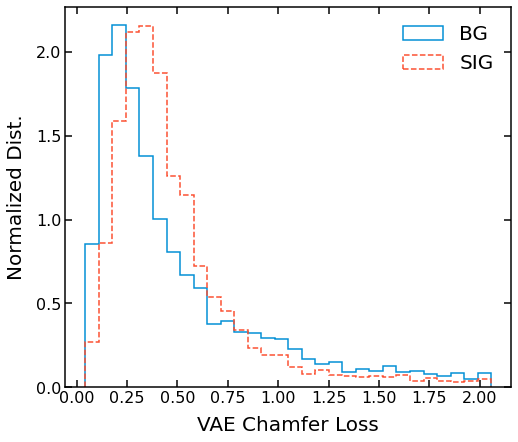

In [66]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

max_score = np.quantile(loss_bg,0.95)#,np.max(loss_bg_dist))
min_score = np.min(loss_bg)#,np.max(loss_bg_dist))
bins = 30
# plot BG
plt.figure()
plt.hist(loss_bg, bins=bins, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=1.5)
plt.hist(loss_sig, bins=bins, label='SIG', density=True, range=(min_score, max_score), 
         histtype='step', linestyle='--',fill=False, linewidth=1.5)
#plt.semilogy()
plt.xlabel("VAE Chamfer Loss")
plt.ylabel("Normalized Dist.")
plt.legend(loc='upper right')
savename = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/reco_edgeconv_ae_test.pdf'
plt.savefig(savename)
plt.show()

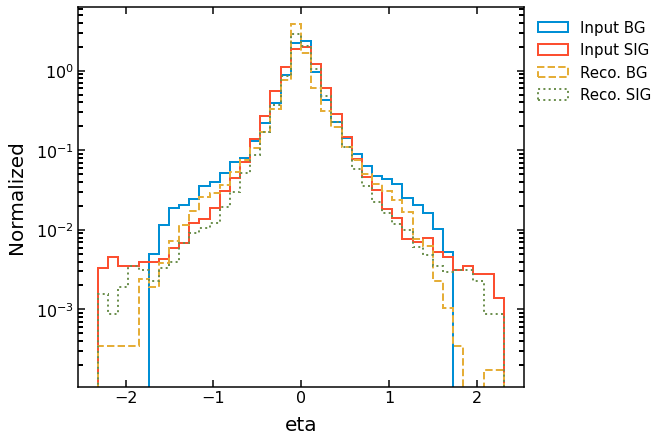

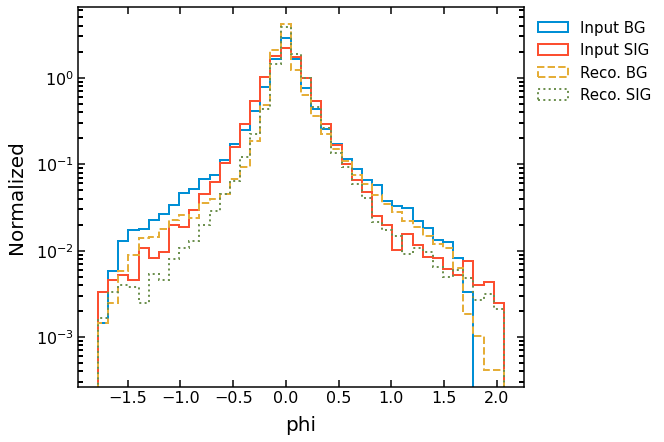

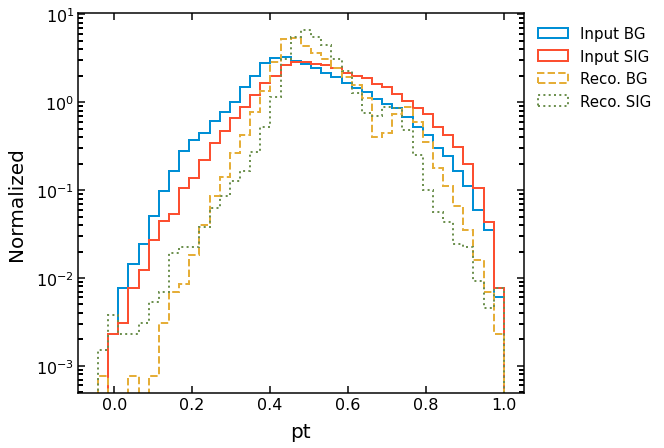

In [67]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
for i in range(0,len(feats)):
    #xmin = np.quantile(particles_bg[:,:,i].flatten(),0.)
    #xmax = np.quantile(particles_bg[:,:,i].flatten(),1)
    xmin = np.min([np.min(particles_bg[:,:,i].flatten()),np.min(Y_bg_predict[:,:,i].flatten())])
    xmax = np.max([np.max(particles_bg[:,:,i].flatten()),np.max(Y_bg_predict[:,:,i].flatten())])
    n_bins = 40
    plot_range = (xmin,xmax)
    plt.figure()
    _,bins,_ = plt.hist(particles_bg_test[:,:,i].flatten(), bins=n_bins, range = plot_range,label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(particles_sig[:,:,i].flatten(), bins=bins, label='Input SIG',density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(Y_bg_predict[:,:,i].flatten(), bins=bins, label='Reco. BG', linestyle='--',density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(Y_sig_predict[:,:,i].flatten(), bins=bins, label='Reco. SIG', linestyle=':',density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
    plt.semilogy()
    savename = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/reco_edgeconv_ae_{}_test.pdf'.format(feats[i])
    plt.savefig(savename)
    plt.show()

In [ ]:
sys.path.append(os.path.abspath(os.path.join('../../vande/')))
sys.path.append(os.path.abspath(os.path.join('../../pofah/')))
sys.path.append(os.path.abspath(os.path.join('../../sarewt/')))
sys.path.append(os.path.abspath(os.path.join('../../')))

In [ ]:
import vande.analysis.analysis_roc as ar
reload(ar)

In [48]:
#neg_class_losses = [loss_bg.tolist(),loss_bg_gnn.tolist(),loss_bg_gvae.tolist()]
#pos_class_losses = [loss_signal.tolist(),loss_signal_gnn.tolist(),loss_signal_gvae.tolist()]
neg_class_losses = [loss_bg.tolist()]
pos_class_losses = [loss_sig.tolist()]

/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")


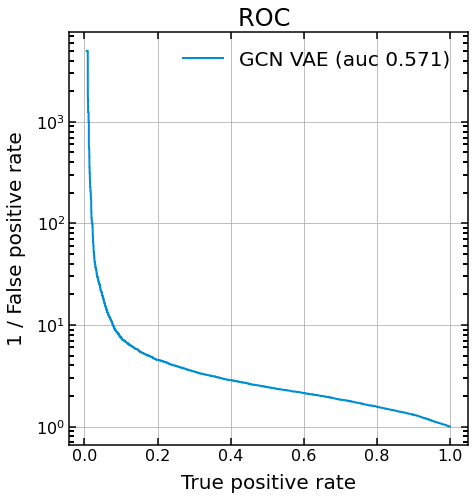

[0.5709508400000001]

In [49]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
#ar.plot_roc( neg_class_losses, pos_class_losses, legend=['GCN VAE','GAE','GVAE'], title='ROC ',
#            plot_name='ROC_text', fig_dir='figs/',log_x=False )
ar.plot_roc( neg_class_losses, pos_class_losses, legend=['GCN VAE'], title='ROC ',
            plot_name='ROC_gcnvae', fig_dir='',log_x=False )


In [ ]:
import models.PNmodel as pn
reload(pn)

In [ ]:
input_shapes = {}
input_shapes['points'] =  [nodes_n,feat_sz-1]
input_shapes['features'] = [nodes_n,feat_sz]
input_shapes['mask'] = None
model = pn.get_particle_net_lite_ae(input_shapes)

In [ ]:
model.summary()

In [ ]:

optim = Adam(learning_rate=0.001)

# Compile the Model
model.compile(optimizer=optim, loss=losses.threeD_loss)
#model.compile(optimizer=optim, loss='mse')

In [ ]:
# early stopping callback
es = EarlyStopping(monitor='val_loss', patience=10)

# Learning rate scheduler 
ls = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10)

history = model.fit((particles_bg[:,:,0:2], particles_bg) , particles_bg,
                    validation_data = ((particles_bg_valid[:,:,0:2], particles_bg_valid) , particles_bg_valid),
                    epochs=3, 
                    batch_size=128, 
                    verbose=1,
                    callbacks=[es,ls]) 

In [ ]:
def mse_loss_manual(inputs, outputs):
    outputs_upd = outputs
    inputs_upd = inputs
    inputs = inputs_upd.reshape(inputs.shape[0],-1) # flatten to tensor of n events, each of size 1024 (32x32)
    outputs = outputs_upd.reshape(outputs.shape[0],-1)
    reconstruction_loss = np.mean( np.square(outputs-inputs), axis=-1)
    return np.array(reconstruction_loss)



In [ ]:
Y_bg_predict = model.predict([particles_bg_test[:,:,0:2],particles_bg_test])
Y_sig_predict = model.predict([particles_sig[:,:,0:2],particles_sig])

In [ ]:
loss_bg = losses.threeD_loss_manual(particles_bg_test,Y_bg_predict)
loss_sig = losses.threeD_loss_manual(particles_sig,Y_sig_predict)

plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

max_score = np.quantile(loss_bg,0.95)#,np.max(loss_bg_dist))
min_score = np.min(loss_bg)#,np.max(loss_bg_dist))
bins = 30
# plot BG
plt.figure()
plt.hist(loss_bg, bins=bins, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=1.5)
plt.hist(loss_sig, bins=bins, label='SIG', density=True, range=(min_score, max_score), 
         histtype='step', linestyle='--',fill=False, linewidth=1.5)
#plt.semilogy()
plt.xlabel("VAE Chamfer Loss")
plt.ylabel("Normalized Dist.")
plt.legend(loc='upper right')
savename = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/reco_edgeconv_ae_test.pdf'
plt.savefig(savename)
plt.show()

In [ ]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
for i in range(0,len(feats)):
    #xmin = np.quantile(particles_bg[:,:,i].flatten(),0.)
    #xmax = np.quantile(particles_bg[:,:,i].flatten(),1)
    xmin = np.min([np.min(particles_bg[:,:,i].flatten()),np.min(Y_bg_predict[:,:,i].flatten())])
    xmax = np.max([np.max(particles_bg[:,:,i].flatten()),np.max(Y_bg_predict[:,:,i].flatten())])
    n_bins = 40
    plot_range = (xmin,xmax)
    plt.figure()
    _,bins,_ = plt.hist(particles_bg_test[:,:,i].flatten(), bins=n_bins, range = plot_range,label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(particles_sig[:,:,i].flatten(), bins=bins, label='Input SIG',density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(Y_bg_predict[:,:,i].flatten(), bins=bins, label='Reco. BG', linestyle='--',density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(Y_sig_predict[:,:,i].flatten(), bins=bins, label='Reco. SIG', linestyle=':',density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
    plt.semilogy()
    savename = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/reco_edgeconv_ae_{}_test.pdf'.format(feats[i])
    plt.savefig(savename)
    plt.show()

In [ ]:
neg_class_losses = [loss_bg.tolist()]
pos_class_losses = [loss_sig.tolist()]

plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
#ar.plot_roc( neg_class_losses, pos_class_losses, legend=['GCN VAE','GAE','GVAE'], title='ROC ',
#            plot_name='ROC_text', fig_dir='figs/',log_x=False )
ar.plot_roc( neg_class_losses, pos_class_losses, legend=['GCN VAE'], title='ROC ',
            plot_name='ROC_gcnvae', fig_dir='',log_x=False )
